# Create Mock Data to the Y3 Pipeline

To validate and test the y3 cluster pipeline we make a simplified mock data of the Buzzard v.1.9.8 dataset. 

Pasting:
- Halo Catalog (truth)
- Paste Mass-Observable Relation
- Shear/$\Delta \Sigma$ profiles (based on Heidi's work)


In [1]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

## Halo Catalog

Before applying a redMaPPer selection we use the true dark matter buzzard mock halo catalog. 

In [2]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')
print('halo file name: %s'%floc.halo_run_fname)

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/buzzard-1.9.8_3y3a_run_halos_lambda_chisq_mu_star.fit


This file contains all buzzard halos with $ M_{200} >10^{12}M_{\odot}$. This catalog also has redMaPPer outputs and $\mu_{\star, \rm true}$.

For more information how this file was created take a look at the source code.
https://github.com/estevesjh/muStarSigmaProfiles/blob/main/notebooks/0.CreateCopacabanaCatalogs.ipynb

In [3]:
### Read Files
data_h, h = fitsio.read(floc.halo_run_fname, header=True)
data, h  = fitsio.read(floc.profile_output_fname, header=True)

#### discard bad halos ####
cosi_all = data['cosi']
pid_all  = data['pid']
redshift_all = data['redshift']
select_good = (pid_all==-1)&(cosi_all>=0)&(cosi_all<=1)##&(self.lam_all > 3)
select_good = select_good & ((redshift_all < 0.33)|(redshift_all > 0.37))

# new variables
redshift = redshift_all[select_good]
profile_all = data['Sigma'][select_good,:]
logMvir = np.log10(data['Mvir'])[select_good]

print('all vs good',len(cosi_all), len(cosi_all[select_good]))

all vs good 1418121 611205


In [4]:
redshift_pdz = data_h['Z']

## Selection Like Y3

I apply two selections, $M_{vir}>10^{13}$ and $z \in [0.2, 0.65]$.

In [5]:
zmin, zmax = 0.2, 0.65
logM_min = 13.0

In [6]:
from astropy.table import Table, join
sel = (redshift>=zmin)&(redshift<=zmax)
sel&= (logMvir>=logM_min)

_mock = Table(data[select_good][sel])

print('Number of halos in mock: %i'%len(_mock))

Number of halos in mock: 580668


In [7]:
_data_h = Table(data_h)
_data_h.rename_column('HALOID', 'haloid')

mock = join(_mock, _data_h)

In [8]:
mock

haloid,Mvir,redshift,cosi,pid,rs,M200m,R200m,Sigma,DeltaSigma,rho,M200,R200,MEM_MATCH_ID,RA,DEC,Z,Z_COS,P_BCG,Z_LAMBDA,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_CHISQ_ZORIG,SCALEVAL,LAMBDA_ZRED,LAMBDA_ZRED_E,MASKFRAC,GEOMASKFRAC,R_LAMBDA,R_MASK,Z_LAMBDA_E,NCROSS,Z_LAMBDA_NITER,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,C_LAMBDA,C_LAMBDA_ERR,MAG_LAMBDA_ERR,PZBINS,PZ,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,BCG_SPEC_Z,LIM_EXPTIME,LIM_LIMMAG_DERED,LIM_LIMMAG,LIM_LIMMAG_HARD,MU_STAR,MU_STAR_ERR
int32,float32,float64,float64,int32,float64,float32,float64,float64[15],float64[15],float64[10],float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32[3],float32[3],float32[4],float32[21],float32[21],float32,float32,float32,float32,float32,float32,float32,float64,float64
927011,67180000000000.0,0.32129502296447754,0.0493361,-1,0.153435,71999500000000.0,1.02684,687.6303158625412 .. 17.94479240757588,-21.009727248105214 .. 2.303207391199313,2178226498771693.5 .. 503991597033.93005,67180000000000.0,0.920502,83659,317.3129287824625,-2.2699395003325264,0.32129502,0.32240096,1.0,0.29508114,11.308149,4.421,11.308149,1.5201979,5.496004,1.8859599,0.34834605,0.0,0.6466634,0.96999514,0.021968598,0,4.0,-0.13628136,-813.556,-25.539,-7945.5103,1.5532275 .. 0.30276462,0.004215956 .. 0.001953539,0.003551543 .. 0.0,0.1319275 .. 0.4582348,4.6803337e-19 .. 1.6777544e-06,0.30003133,0.019447086,-1.0,0.060046393,21.323307,21.323307,23.33665,55.13490186726909,15.129583717781587
927998,19660000000000.0,0.3205868899822235,0.178295,-1,0.183352,22303100000000.0,0.694974,311.34160504036714 .. 18.374717459592997,37.19347864947478 .. 1.2994938365065096,1373541979616634.8 .. 305181131216.41174,19660000000000.0,0.61103,583836,317.75202896886884,-1.949667563663084,0.3205869,0.32168326,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.042421903,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,-1.0,0.19611365,22.218992,22.231089,23.33665,41.92753971791975,14.28440131000884
2545389,68890000000000.0,0.27058446407318115,0.37468,-1,0.223423,91154710000000.0,1.11086,469.1737007476693 .. 15.90097191373355,115.09039698599864 .. 2.753597969323336,2219173286702298.8 .. 1519260804499.2036,68890000000000.0,0.917785,79738,307.15073025389347,-42.0517754044981,0.27058446,0.27059728,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.027480915,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,-1.0,0.17292078,22.134556,22.134556,23.33665,75.17978438169001,28.065401761466184
2545393,88940000000000.0,0.27038249373435974,0.557151,-1,0.55728,105052300000000.0,1.16474,542.0784591288408 .. 16.14773575478276,-57.00905916180685 .. 2.5884544516698047,1642214180825270.8 .. 920412980488.0205,88940000000000.0,0.999439,49132,307.27470671757794,-42.05313550692125,0.2703825,0.27077192,1.0,0.2726077,12.909922,2.2422812,12.909922,1.0107747,8.592764,1.683498,0.011844758,0.0,0.6640254,0.99603814,0.012795136,1,7.0,16.436996,-4891.07,54.50159,-19902.953,1.4195611 .. 0.29340506,0.0006993837 .. 0.00028456797,0.0005785313 .. 0.0,0.19574621 .. 0.3494692,6.227082e-10 .. 2.574587e-06,0.27617714,0.009283012,-1.0,0.17907387,22.145226,22.161373,23.33665,81.77789884880814,21.3046707925232
2545753,76890000000000.0,0.263835608959198,0.125772,-1,0.162836,81108270000000.0,1.06845,531.6249357975245 .. 17.51952583340207,124.49326826468936 .. 1.566832787886304,2128660225006729.0 .. 356406746880.90045,76890000000000.0,0.950669,64954,308.4656671879389,-39.82394748123761,0.2638356,0.2644128,1.0,0.24406444,12.757372,2.730836,12.757372,1.1628395,7.357111,1.6438206,0.14655606,0.0,0.6624487,0.9936731,0.010842432,1,5.0,-3.626756,-878.77856,8.034127,-3581.3113,1.3601099 .. 0.27888802,0.0005536285 .. 0.00039728833,0.0004455281 .. 0.0,0.17095098 .. 0.3171779,1.34302005e-11 .. 2.8216637e-06,0.24525408,0.0085574

In [9]:
## clear memory
data_h = data = 0
_mock = _data_h = 0

## Distributions

(array([ 19717.,  35200.,  38023.,  43933.,  85547., 107626.,  96489.,
         67724.,  58388.,  30396.]),
 array([-61.5816496 , -45.36618242, -29.15071525, -12.93524807,
          3.2802191 ,  19.49568628,  35.71115345,  51.92662063,
         68.1420878 ,  84.35755498, 100.57302216]),
 <BarContainer object of 10 artists>)

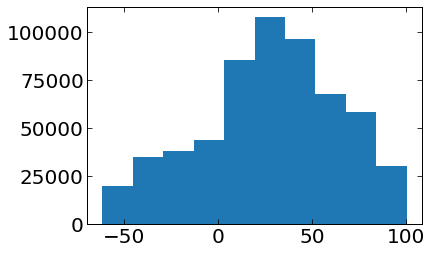

In [10]:
ra = mock['RA']
ix, = np.where(ra>180)
ra[ix] = ra[ix]-360
plt.hist(ra)

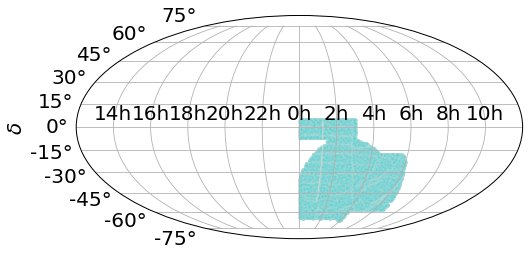

In [11]:
from astropy.coordinates import SkyCoord
from astropy import units as u

# Plotting sky distribution
ra = mock['RA']
ix, = np.where(ra>180)
ra[ix] = ra[ix]-360
dec= mock['DEC']

c = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree))
#Coordinates needs to be in radians from (-pi,pi) & (-pi/2, pi/2)
a = c.ra.to('radian').value
d = c.dec.to('radian').value

#make figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='mollweide' ) # hammer or mollweide, aitoff, or lambert 
ax.scatter(a,d, marker='.', color='c', alpha=0.05, edgecolors='w')
ax.grid(True)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h']) 
plt.ylabel(r'$\delta$')
plt.show()


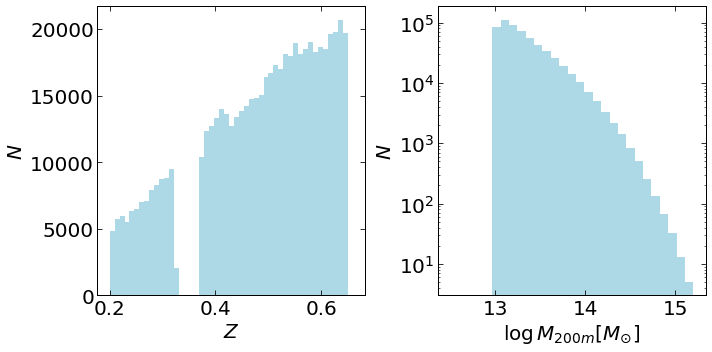

In [12]:
# Histrograms of mass and redshifts 
logMvir = np.log10(mock['Mvir'])
z = np.array(mock['redshift'])

zbins = np.linspace(0.2, 0.66, num=50)
#mbins = np.linspace(3e13, 2e15, num=30)
mbins = np.linspace(12.5, 15.2, num=30)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(z, bins=zbins, color='lightblue', density=False)
axes[0].set_xlabel('$Z$')
axes[0].set_ylabel('$N$')

axes[1].hist(logMvir, bins=mbins, color='lightblue')
axes[1].set_xlabel('$\log M_{200m} [M_{\odot}]$')
axes[1].set_ylabel('$N$')
axes[1].set_yscale('log')
fig.tight_layout()
plt.show()

The break on redshift is a selection to avoid the switch of the simulation box resolution. 

In [13]:
print('Save file: %s'%floc.mock_fname)
mock.write(floc.mock_fname, format='fits', overwrite=True)

Save file: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0.fits


# Mass Observable Relation

Altough we have redMaPPer richness in our catalog. We will first use a fixed one in order for testing and validation. 

The lines below were compied from Maria's notebook.


## Assigning richness and $\mu_{\star}$ 

We know the mass-calibration results from McClintock et al (2018) and Pereira et. al (2020). 

### Scaling Relatioons (with redshift evolution)

We have that

$$ \langle M|\mu_{\star},z \rangle =  M_0 \left( \frac{\mu_{\star}}{5.2 \times 10^{12}} \right)^a \left( \frac{1+z}{1.35} \right)^b. $$

Taking the log

$$ \langle \log M | \mu_{\star},z \rangle = a  \log \left( \frac{\mu_{\star}}{5.2 \times 10^{12}} \right) + b \log \left( \frac{1+z}{1.35} \right) + c $$



Inverting this relation, we get:

$$ \langle \log \mu_{\star}|M,z \rangle = \frac{1}{a} \left( \log M - b \log \left( \frac{1+z}{1.35}\right) - c  \right) + \log(5.2 \times 10^{12}), $$

whith $a=0.77 \pm 0.06, \, b= -1.54 \pm 0.37 \, \mathrm{and} \, c=\log M_0 = 14.30 \pm 0.02 \, [M_\odot]$.



Similarly, for log &lambda;:

$$ \langle \log \lambda|M,z \rangle = \frac{1}{a} \left( \log M - b \log \left( \frac{1+z}{1.35}\right) - c  \right) + \log(40), $$

whith $a=1.36 \pm 0.05, \, b=-0.30 \pm 0.31 \, \mathrm{and} \, c= \log M_0 = 14.49 \pm 0.02 \,[M_\odot] $.



And doing error propagation to get the error, we get (**this is wrong**):

$$ \sigma_{\log \mu_{\star|M,z}} = \sqrt{ \left( - \left( \log M - b \log\left( \frac{1+z}{1.35}\right) \right) a^{-2} \sigma_a \right)^2 + \left( -\frac{1}{a} \log \left( \frac{1+z}{1.35}\right) \sigma_b \right)^2 + \left(-\frac{\sigma_c}{a}\right)^2   } $$


Note that all masses are (or were converted to) in units of $M_{200m} [M_{\odot}]$.


Now, we should assign &lambda; and $\mu_{\star}$ for this sample. Jim have found that the relationship between observables _s_ and mass _M_ should be in the form: 

$$\langle \log s | M \rangle = \frac{\log M - b}{a} - \frac{\beta \ln 10}{a^2} \sigma^2_{\log M} $$


## Adding scatter

The variance of the mean relations above between the observables s and mass M should be in the form:

$$ \sigma_{\log s} = \frac{\sigma_{\log M}}{a}$$


In [14]:
def get_log_lambda(logM, z, a, b, c):
    return (1./a)*(logM - b*np.log10((1+z)/1.35) - c) + np.log10(40)

def get_log_mustar(logM, z, a, b, c):
    return (1./a)*(logM - b*np.log10((1+z)/1.35) - c) + np.log10(5.2e12)

def get_sigma_log_mustar(logM, z, a, sigma_a, b, sigma_b, c, sigma_c):
    return np.sqrt( ( -a**(-2)*sigma_a*(logM - b*np.log10((1.+z)/1.35)) )**2 + ( (-1./a)*np.log10((1+z)/1.35)*sigma_b )**2+ (-sigma_c/a)**2 )


In [15]:
# getting mock data

log_M = np.log10(mock['Mvir'])
z = np.array(mock['redshift'])

In [16]:
# Assigning lambda and mustar for the halos
mpivot = 5.2e12

# assigning lambda
log_lambda = get_log_lambda(log_M, z, 1.36, -0.30, 14.49)

#Assuming 10% scatter...
sig_loglam = 0.15

#Adding scatter
log_lambda_sc = np.array([np.random.normal(n, sig_loglam) for n in log_lambda])

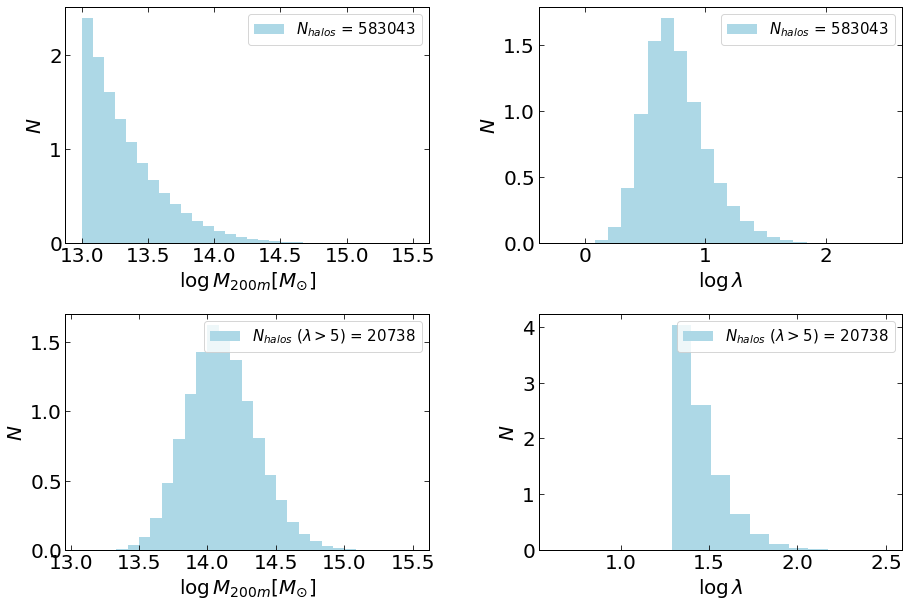

In [17]:
# Histrograms of mass and richness

mbins   = np.linspace(13.0, 15.5, num=31)
rbins   = np.linspace(-0.25, 2.5, num=26)
N       = len(log_lambda_sc)

log_lg5 = (log_lambda_sc>=np.log10(20))
Nlg5    = len(log_lambda_sc[log_lg5])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes[0,0].hist(log_M, bins=mbins, color='lightblue', density=True, label="$N_{halos}$ = "+ str(N))
axes[0,0].set_xlabel('$\log M_{200m} [M_{\odot}]$')
axes[0,0].set_ylabel('$N$')
axes[0,0].legend(loc="best", fontsize=15)

axes[0,1].hist(log_lambda_sc, bins=rbins, color='lightblue', density=True, label="$N_{halos}$ = "+ str(N))
axes[0,1].set_xlabel('$\log \lambda$')
axes[0,1].set_ylabel('$N$')
axes[0,1].legend(loc="best", fontsize=15)

axes[1,0].hist(log_M[log_lg5], bins=mbins[1:,], color='lightblue', density=True, label="$N_{halos}$ ($\lambda>5$) = "+ str(Nlg5))
axes[1,0].set_xlabel('$\log M_{200m} [M_{\odot}]$')
axes[1,0].set_ylabel('$N$')
axes[1,0].legend(loc="best", fontsize=15)

axes[1,1].hist(log_lambda_sc[log_lg5], bins=rbins[8:,], color='lightblue', density=True, label="$N_{halos}$ ($\lambda>5$) = "+ str(Nlg5))
axes[1,1].set_xlabel('$\log \lambda$')
axes[1,1].set_ylabel('$N$')
axes[1,1].legend(loc="best", fontsize=15)

fig.subplots_adjust(wspace=0.3, hspace=0.3)
#fig.tight_layout()
plt.show()

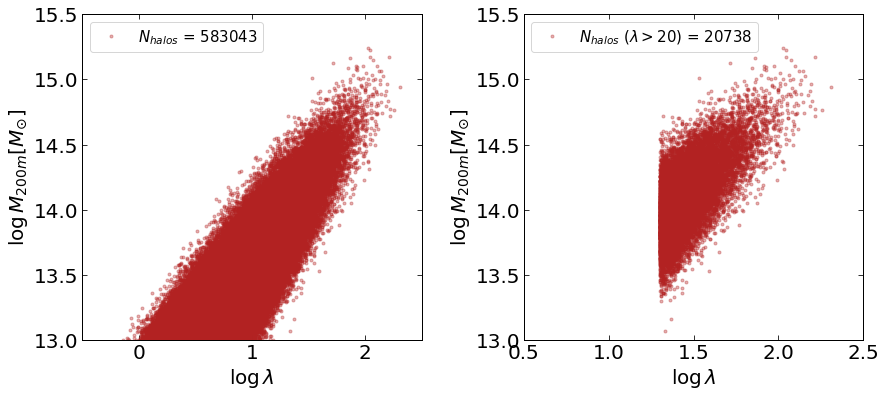

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].plot(log_lambda_sc, log_M, '.', color='firebrick', alpha=0.35, label='$N_{halos}$ = '+str(N))
axes[0].set_xlabel('$\log \lambda$')
axes[0].set_ylabel('$\log M_{200m} [M_{\odot}]$')
axes[0].set_xlim(-0.5, 2.5)
axes[0].set_ylim(13.0, 15.5)
axes[0].legend(loc="best", fontsize=15)

axes[1].plot(log_lambda_sc[log_lg5], log_M[log_lg5], '.', color='firebrick', alpha=0.35,  label='$N_{halos}$ ($\lambda>20$) = '+str(Nlg5)) 
axes[1].set_xlabel('$\log \lambda$')
axes[1].set_ylabel('$\log M_{200m} [M_{\odot}]$')
axes[1].set_xlim(0.5, 2.5)
axes[1].set_ylim(13.0, 15.5)
axes[1].legend(loc="best", fontsize=15)

fig.subplots_adjust(wspace=0.3)
plt.show()

# Adding correlation between the observables


We need to recompute the mean relation <**s**|M>, where **s** is as vector of obersvables {log &lambda;, log $\mu_{\star}$}. From Rozo et al. 2014 and Evrard et al. 2014, Oguri et al. 2018, we have:


$$\langle \mathbf{s} | M \rangle = \left[ \mathbf{\alpha}^T \mathbf{C}^{-1} (\mathbf{\mu} - \pi) - \mathbf{\beta} \ln{(10)} \right] \sigma_{\mathbf{s}|M}^2,$$
with

$$ \sigma_{\mathbf{s}|M}^2 = \left( \mathbf{\alpha}^T \mathbf{C}^{-1}  \mathbf{\alpha} \right)^{-1}   $$
where

$$ \mathbf{\mu} = \begin{pmatrix}
\log M \\
\log M 
\end{pmatrix} $$

$$ \mathbf{\alpha} = \begin{pmatrix}
a_{\lambda} \\
a_{\mu_{\star}} 
\end{pmatrix} $$

$$ \mathbf{\pi} = \begin{pmatrix}
b_{\lambda} \\
b_{\mu_{\star}} 
\end{pmatrix} $$

$$ \mathbf{\beta} = \begin{pmatrix}
\beta_{\lambda} \\
\beta_{\mu_{\star}} 
\end{pmatrix} $$


$$ \mathbf{C} = \begin{pmatrix}
\sigma_{\log \lambda | M}^2 & r \cdot \sigma_{\log \lambda | M}  \cdot \sigma_{\log \mu_\star|M}  \\
r \cdot  \sigma_{\log \mu_\star|M} \cdot \sigma_{\log \lambda|M}  & \sigma_{\log \mu_\star|M}^2 
\end{pmatrix} $$

The pearson correlation for log &lambda; and log $\mu_{\star}$ is r =0.622. 

Since the scatters can be computed as

$$ \sigma_{\log{s}|M} = \frac{ \sigma_{\log{M}|s} }{a_s}, $$

we have that

$$ \sigma_{\log{\lambda}|M} = \frac{ \sigma_{\log{M}|\lambda} }{a_\lambda} = \frac{0.13}{1.36} = 0.0956$$

$$ \sigma_{\log{\mu_\star}|M} = \frac{ \sigma_{\log{M}|\mu_\star} }{a_{\mu_\star}} = \frac{0.11}{0.77} = 0.1429$$


In [19]:
alphas = np.array([ [1.36], [1.0] ])
alphas_T = np.transpose(alphas)

pis = np.array([ [14.49], [14.30] ])

betas = np.array([ [3.5], [1.67] ])

r = 0.622
sig_lMlam = 0.13
sig_lMmus = 0.11
sig_llamM = 0.0956
sig_lmusM = 0.1429

C = np.array([[ sig_llamM**2, r*sig_llamM*sig_lmusM],[r*sig_llamM*sig_lmusM, sig_lmusM**2]])
iC = np.linalg.inv(C) 


In [20]:
def s_given_M_corr(logM, alphas_, alphasT_, icov, pis_, betas_ ):

    sig2_sM = (np.dot(np.dot(alphas_T, iC), alphas))**(-1) #(np.dot(alphas_T * iC, alphas) )**(-1) 
    sig2_sM = sig2_sM[0][0]                                #just get the number from this 1x1 'matrix'

    lamM=[]
    muM =[]
    for i in range(len(logM)):
        mus = np.array([ [log_M[i]], [log_M[i]] ]) 
        sM = (np.dot(np.dot(alphas_T,iC),(mus-pis)) - betas*np.log(10)) * sig2_sM
        lamM.append(sM[0]) 
        muM.append(sM[1])

    sM_scatter = np.sqrt(sig2_sM)

    #print sM
    print(sM_scatter)
    return np.array(lamM), np.array(muM), sM_scatter 
    


In [21]:
sM0, sM1, sM_sig = s_given_M_corr(log_M, alphas, alphas_T, iC, pis, betas) 

lpivot = 40.
mpivot = 5.2e12

lambda_corr      = lpivot*10**sM0
log_lambda_corr   = np.log10(lambda_corr)
#print log_lambda_corr, lambda_corr

mustar_corr     = mpivot*10**sM1 
log_mustar_corr = np.log10(mustar_corr)

#print log_mustar_corr, mustar_corr

print(sM_sig)

0.06934362857768142
0.06934362857768142


In [22]:
#Adding scatter

log_lambda_corr_sc = np.array([np.random.normal(n, sM_sig) for n in log_lambda_corr])
log_mustar_corr_sc = np.array([np.random.normal(n, sM_sig) for n in log_mustar_corr])

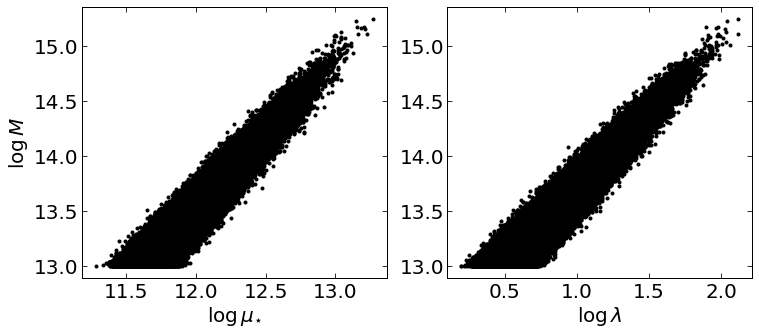

In [23]:
fig = plt.figure(figsize=(12, 5))
#mean relation Mxmu* with scatter
plt.subplot(121)
plt.plot(log_mustar_corr_sc, log_M, 'k.')
plt.xlabel('$\log \mu_{\star}$')
plt.ylabel('$\log M$')

#mean relation Mx lambda with scatter
plt.subplot(122)
plt.plot(log_lambda_corr_sc, log_M, 'k.')
plt.xlabel('$\log \lambda$')
# plt.ylabel('$\log M$')
plt.show()

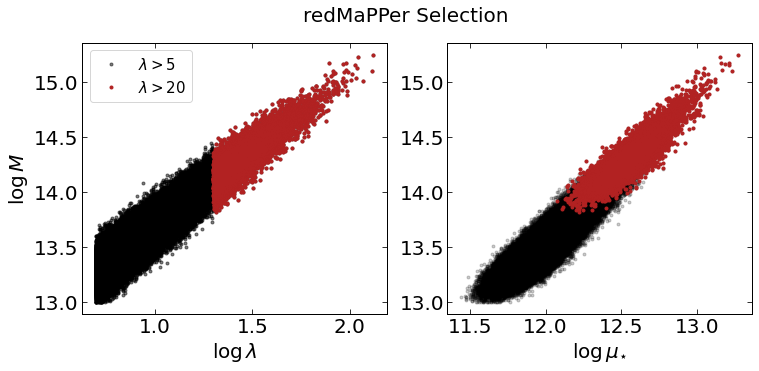

In [24]:
log_lg20 = log_lambda_corr_sc.flatten() > np.log10(20)
log_lg5 = log_lambda_corr_sc.flatten() > np.log10(5)
mask = log_lg20

fig = plt.figure(figsize=(12, 5))

#mean relation Mx lambda with scatter
plt.subplot(121)
plt.plot(log_lambda_corr_sc[log_lg5], log_M[log_lg5], '.', color='k', alpha=0.5, label=r'$\lambda>5$')
plt.plot(log_lambda_corr_sc[log_lg20], log_M[log_lg20], '.', color='firebrick', label=r'$\lambda>20$')
plt.xlabel('$\log \lambda$')
plt.ylabel('$\log M$')
plt.legend(fontsize=15)


#mean relation Mxmu* with scatter
plt.subplot(122)
plt.plot(log_mustar_corr_sc[log_lg5], log_M[log_lg5], '.', color='k', alpha=0.2)
plt.plot(log_mustar_corr_sc[log_lg20], log_M[log_lg20], '.', color='firebrick')
plt.xlabel('$\log \mu_{\star}$')

fig.suptitle('redMaPPer Selection', fontsize=20)
plt.savefig('mock_mor_redmapper_sel.png', dpi=75, facecolor='w', transparent=False)

In [25]:
# add mu-star and lambda to the mocks
mock['lambda_mor'] = 10**log_lambda_corr_sc.flatten()
mock['mustar_mor'] = 10**log_mustar_corr_sc.flatten()

In [26]:
# save output
print('Save file: %s'%floc.mock_fname)
mock.write(floc.mock_fname, format='fits', overwrite=True)

Save file: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0.fits


In [27]:
mock.columns

<TableColumns names=('haloid','Mvir','redshift','cosi','pid','rs','M200m','R200m','Sigma','DeltaSigma','rho','M200','R200','MEM_MATCH_ID','RA','DEC','Z','Z_COS','P_BCG','Z_LAMBDA','LAMBDA_CHISQ','LAMBDA_CHISQ_E','LAMBDA_CHISQ_ZORIG','SCALEVAL','LAMBDA_ZRED','LAMBDA_ZRED_E','MASKFRAC','GEOMASKFRAC','R_LAMBDA','R_MASK','Z_LAMBDA_E','NCROSS','Z_LAMBDA_NITER','DLAMBDA_DZ','DLAMBDA_DZ2','DLAMBDAVAR_DZ','DLAMBDAVAR_DZ2','C_LAMBDA','C_LAMBDA_ERR','MAG_LAMBDA_ERR','PZBINS','PZ','Z_LAMBDA_RAW','Z_LAMBDA_E_RAW','BCG_SPEC_Z','LIM_EXPTIME','LIM_LIMMAG_DERED','LIM_LIMMAG','LIM_LIMMAG_HARD','MU_STAR','MU_STAR_ERR','lambda_mor','mustar_mor')>

## $\Delta \Sigma$ Profiles

The $\Delta \Sigma$ profiles showed here were used on the work Wu et al. 2022. Here we show some examples

In [28]:
import radial_bins_phys_mpc as rbp

radii = rbp.rp_phys_mpc


Text(0, 0.5, '$\\Delta \\Sigma \\, \\, [M_{\\odot}]$')

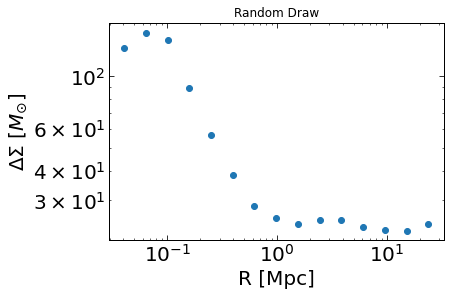

In [29]:
ix = np.random.randint(profile_all.shape[0])
# ix = 3
plt.loglog()
plt.scatter(radii, profile_all[ix])
plt.title('Random Draw')
plt.xlabel(r'R [Mpc]')
plt.ylabel(r'$\Delta \Sigma \, \, [M_{\odot}]$')

In [30]:
mock

haloid,Mvir,redshift,cosi,pid,rs,M200m,R200m,Sigma,DeltaSigma,rho,M200,R200,MEM_MATCH_ID,RA,DEC,Z,Z_COS,P_BCG,Z_LAMBDA,LAMBDA_CHISQ,LAMBDA_CHISQ_E,LAMBDA_CHISQ_ZORIG,SCALEVAL,LAMBDA_ZRED,LAMBDA_ZRED_E,MASKFRAC,GEOMASKFRAC,R_LAMBDA,R_MASK,Z_LAMBDA_E,NCROSS,Z_LAMBDA_NITER,DLAMBDA_DZ,DLAMBDA_DZ2,DLAMBDAVAR_DZ,DLAMBDAVAR_DZ2,C_LAMBDA,C_LAMBDA_ERR,MAG_LAMBDA_ERR,PZBINS,PZ,Z_LAMBDA_RAW,Z_LAMBDA_E_RAW,BCG_SPEC_Z,LIM_EXPTIME,LIM_LIMMAG_DERED,LIM_LIMMAG,LIM_LIMMAG_HARD,MU_STAR,MU_STAR_ERR,lambda_mor,mustar_mor
int32,float32,float64,float64,int32,float64,float32,float64,float64[15],float64[15],float64[10],float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32[3],float32[3],float32[4],float32[21],float32[21],float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
927011,67180000000000.0,0.32129502296447754,0.0493361,-1,0.153435,71999500000000.0,1.02684,687.6303158625412 .. 17.94479240757588,-21.009727248105214 .. 2.303207391199313,2178226498771693.5 .. 503991597033.93005,67180000000000.0,0.920502,83659,-42.68707121753749,-2.2699395003325264,0.32129502,0.32240096,1.0,0.29508114,11.308149,4.421,11.308149,1.5201979,5.496004,1.8859599,0.34834605,0.0,0.6466634,0.96999514,0.021968598,0,4.0,-0.13628136,-813.556,-25.539,-7945.5103,1.5532275 .. 0.30276462,0.004215956 .. 0.001953539,0.003551543 .. 0.0,0.1319275 .. 0.4582348,4.6803337e-19 .. 1.6777544e-06,0.30003133,0.019447086,-1.0,0.060046393,21.323307,21.323307,23.33665,55.13490186726909,15.129583717781587,8.681998243438684,1308149508495.1855
927998,19660000000000.0,0.3205868899822235,0.178295,-1,0.183352,22303100000000.0,0.694974,311.34160504036714 .. 18.374717459592997,37.19347864947478 .. 1.2994938365065096,1373541979616634.8 .. 305181131216.41174,19660000000000.0,0.61103,583836,-42.24797103113116,-1.949667563663084,0.3205869,0.32168326,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.042421903,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,-1.0,0.19611365,22.218992,22.231089,23.33665,41.92753971791975,14.28440131000884,4.0395414647380345,626435894455.5984
2545389,68890000000000.0,0.27058446407318115,0.37468,-1,0.223423,91154710000000.0,1.11086,469.1737007476693 .. 15.90097191373355,115.09039698599864 .. 2.753597969323336,2219173286702298.8 .. 1519260804499.2036,68890000000000.0,0.917785,79738,-52.84926974610653,-42.0517754044981,0.27058446,0.27059728,1.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.027480915,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,-1.0 .. -1.0,-1.0 .. -1.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0,0.0,-1.0,0.17292078,22.134556,22.134556,23.33665,75.17978438169001,28.065401761466184,10.062862533601052,1618487932632.6829
2545393,88940000000000.0,0.27038249373435974,0.557151,-1,0.55728,105052300000000.0,1.16474,542.0784591288408 .. 16.14773575478276,-57.00905916180685 .. 2.5884544516698047,1642214180825270.8 .. 920412980488.0205,88940000000000.0,0.999439,49132,-52.72529328242206,-42.05313550692125,0.2703825,0.27077192,1.0,0.2726077,12.909922,2.2422812,12.909922,1.0107747,8.592764,1.683498,0.011844758,0.0,0.6640254,0.99603814,0.012795136,1,7.0,16.436996,-4891.07,54.50159,-19902.953,1.4195611 .. 0.29340506,0.0006993837 .. 0.00028456797,0.0005785313 .. 0.0,0.19574621 .. 0.3494692,6.227082e-10 .. 2.574587e-06,0.27617714,0.009283012,-1.0,0.17907387,22.145226,22.161373,23.33665,81.77789884880814,21.3046707925232,19.507735487705173,1894700385442.0505
2545753,76890000000000.0,0.263835608959198,0.125772,-1,0.162836,81108270000000.0,1.06845,531.6249357975245 .. 17.51952583340207,124.49326826468936 .. 1.566832787886304,2128660225006729.0 .. 356406746880.90045,76890000000000.0,0.950669,64954,-51.53433281206111,-39.82394748123761,0.2638356,0.2644128,1.0,0.24406444,12.757372,2.730836,12.757372,1.1628395,7.357111,1.6438206,0.14655606,0.0,0.6624487,0.9936731,0.010842432,1,5.0,-

# Effective $\Sigma_{\rm c}$ 

The crital density is for a given object. For instance, when a galaxy is observed on an Einstein ring the critical density of that observation is the redshift of the source galaxy. In the weak lensing regime, we have several sources. Our sources depends of how many galaxies we select, i.e. the galaxies by a given survey.

If we had a complete catalog the sources would be all the galaxies behind the cluster. And the redshift distribution would increase monotonichally.

In [31]:
zbins = np.linspace(0.05, 0.94, 21)
zmean = 0.5*(zbins[:-1] + zbins[1:])
pdfz, _ = np.histogram(redshift_pdz, bins=zbins, density=True)

In [32]:
from scipy.interpolate import interp1d
zsources = np.linspace(0.1, 1.3, 100)
pz = interp1d(zmean, pdfz, fill_value="extrapolate")(zsources)

### Selection Function

A survey is magnitude limited. Magnitude selection is very different of volume limited. High redshift galaxies if they're brighter they appear in our selection. This effect is well known and its name is Malquimist Bias. In this mock we will do something simple, a redshift limit with a tail. We use a function that looks like the magnitude selection. In the future I hope to improve this redshift selection function.

In [33]:
def completeness_formula(m, A=0.94, m50=24.88, rho=0.65):
    """ Completeness functional form
    See eq 7 from Martin et al. 2016
    """
    # modidfication for redshift
    rho*= (1+m)
    denominator = 1+np.exp((m-m50)/rho)
    res = A/denominator
    return res

# based on the completeness formula I'll do something to redshift
# des redshift limit
zlim = 0.8
# redshift window size of redshift falling
z_window_length = 0.05
sel_function = completeness_formula(zsources, m50= zlim, rho=z_window_length)

In [34]:
# help(interp1d)

Text(0, 0.5, 'p(z)')

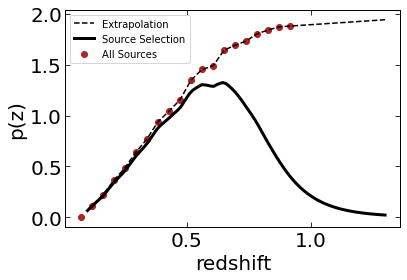

In [35]:
plt.plot(zsources, pz, 'k--', label='Extrapolation')
plt.plot(zsources, pz*sel_function, 'k', lw=3, label='Source Selection')
plt.scatter(zmean, pdfz, color='firebrick', label='All Sources')
plt.legend()
plt.xlabel('redshift')
plt.ylabel(r'p(z)')

In [36]:
print('save z source distribution: %s'%'pdfz_mock_buzzrd_y3like.npz')
pz_norm = pz*sel_function/np.trapz(pz*sel_function,x=zsources)
np.savez('pdfz_mock_buzzrd_y3like.npz', z=zsources, pdfz=pz_norm)

save z source distribution: pdfz_mock_buzzrd_y3like.npz


In [37]:
pzsel = np.load('pdfz_mock_buzzrd_y3like.npz')

## Compute Critical Density

In [38]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
cosmo0 

FlatLambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

In [39]:
# pz interp
pz_interp = interp1d(pzsel['z'], pzsel['pdfz'], fill_value='extrapolate')

In [40]:
# for a given zl
zl = 0.2
delta_z = 0.1
z_source_vec = np.linspace(zl, 1.2, 100)

# compute the normalized p(z_source)
heaviside = np.where(z_source_vec>=zl+delta_z*(1+zl), 1, 0)
pz_vec = heaviside*pz_interp(z_source_vec)
pz_vec /= np.trapz(pz_vec, x=z_source_vec)

# compute comving distances
dl = cosmo0.comoving_distance(zl).value

# compute betas
ds = cosmo0.comoving_distance(z_source_vec).value
dsl = ds-dl
beta = dsl/ds

# integrate over betas
beta_mean = np.trapz(pz_vec*beta, x=z_source_vec)

# effective redshift source
z_src_eff = np.interp(beta_mean, beta, z_source_vec)


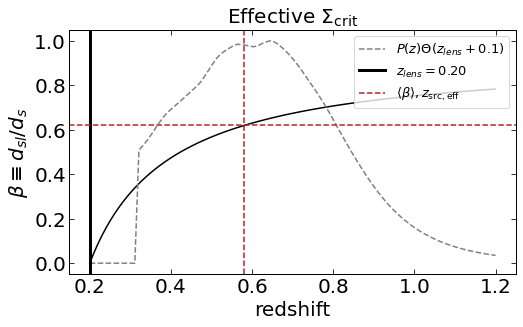

In [41]:
plt.figure(figsize=(8,4.5))
plt.plot(z_source_vec, beta, color='k')
plt.plot(z_source_vec, pz_vec/(np.max(pz_vec)),color='gray',ls='--', label=r'$P(z) \Theta(z_{lens}+0.1)$')

plt.axvline(zl, color='k', lw=3, label=r'$z_{lens} = %.2f$'%(zl))
plt.axhline(beta_mean, color='firebrick', ls='--')
plt.axvline(z_src_eff, color='firebrick', ls='--', label=r'$\left< \beta \right>, z_{\rm src, eff}$')

plt.xlabel('redshift')
plt.ylabel(r'$\beta \equiv d_{sl}/d_{s} $')
plt.legend(fontsize=13, loc=1)
plt.title(r'Effective $\Sigma_{\rm crit}$',fontsize=20)
plt.savefig('mock_beta_evolution.png', dpi=75, facecolor='w', transparent=False)

In [42]:
def compute_z_src_eff(zl, delta_z=0.1, cosmo=cosmo0):
    # for a given zl
    z_source_vec = np.linspace(zl, 1.2, 100)

    # compute the normalized p(z_source)
    heaviside = np.where(z_source_vec>=zl+delta_z*(1+zl), 1, 0)
    pz_vec = heaviside*pz_interp(z_source_vec)
    pz_vec /= np.trapz(pz_vec, x=z_source_vec)

    # compute comving distances
    dl = cosmo.angular_diameter_distance(zl).value

    # compute betas
    ds = cosmo.angular_diameter_distance(z_source_vec).value
    dsl = cosmo.angular_diameter_distance_z1z2(zl, z_source_vec).value
    beta = dsl/ds

    # integrate over betas
    beta_mean = np.trapz(pz_vec*beta, x=z_source_vec)

    # effective redshift source
    z_src_eff = np.interp(beta_mean, beta, z_source_vec)
    
    return z_src_eff, beta_mean


### Dependence of $z_{\rm lens}$

In [43]:
print('Some important effective values')
for zl in [0.2, 0.3, 0.6]:
    zi, bi = compute_z_src_eff(zl, cosmo=cosmo0)
    print('zl, zs, beta: %.2f, %.2f, %.3f'%(zl, zi,bi))

Some important effective values
zl, zs, beta: 0.20, 0.58, 0.620
zl, zs, beta: 0.30, 0.64, 0.489
zl, zs, beta: 0.60, 0.87, 0.259


In [44]:
zarray = np.linspace(0.05, 1.2, 50)
z_eff_sources = np.array([compute_z_src_eff(zl, cosmo=cosmo0)[0] for zl in zarray])
b_eff_sources = np.array([compute_z_src_eff(zl, cosmo=cosmo0)[1] for zl in zarray])

/tmp/ipykernel_207420/3409663859.py:8: RuntimeWarning: invalid value encountered in true_divide
  pz_vec /= np.trapz(pz_vec, x=z_source_vec)


Text(0.5, 1.0, 'Effective :$\\left<\\beta\\right>$')

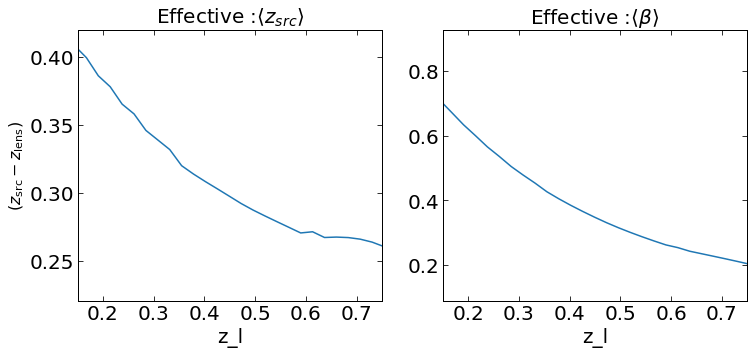

In [45]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(zarray, (z_eff_sources-zarray))
plt.xlim(0.15, 0.75)
plt.ylim(0.22, 0.42)
_ = plt.xticks(np.linspace(0.2, 0.7, 6))
plt.xlabel('z_l')
plt.ylabel(r'$(z_{\rm src} - z_{\rm lens})$', fontsize=16)
plt.title(r'Effective :$\left<z_{src}\right>$', fontsize=20)

plt.subplot(122)
plt.plot(zarray, b_eff_sources)
plt.xlim(0.15, 0.75)
_ = plt.xticks(np.linspace(0.2, 0.7, 6))
plt.xlabel('z_l')
plt.title(r'Effective :$\left<\beta\right>$', fontsize=20)
# plt.plot(zarray, beta)

## Modeling Boost-Factor

We model the observed redshift distribution in the line-of-sight of a cluster. Because of the photo-z selection, there are cluster galaxies which leaks into the source selection. We can account the leakage in the selection by modeling the observed photo-z distribution as a function of the radii. 

By assuming a given cluster photo-z distribution we can decompose the observed photo-z distribution as:
$$
P_{\rm observed}(z, R) = f_{\rm cls}(R)*P_{\rm cls}(z) + (1-f_{\rm cls}(R))*P(z) \; .
$$

For instance, for the cluster photo-z distribution we will assume a lorentiaz distribution
$$
P_{\rm cls} (z| z_0, \gamma) = \frac{1}{\pi \gamma \left[1+\left(\frac{z-z_0}{\gamma}\right)^2\right]}
$$
Where $z_0$ and $\gamma$ are the redshift median and the $\sigma_{z, \rm NMAD}$ respectively.

The $f_{\rm cls}(R)$ will use from the boost-factor model.

In [46]:
from setup_bins import lbdbins, zbins

print('lambda bins:', lbdbins)
print('redshift bins:', zbins)

lambda bins: [  5  20  30  45  60 900]
redshift bins: [0.2  0.35 0.5  0.65]


In [47]:
lbdbins = np.array([5, 10, 14, 20, 30, 45, 60, 130])
lbdmean = lbdbins[1:] + np.diff(lbdbins)/2.

### Modeling of $f_{\rm cl}(R)$

In [475]:
path_boost = floc.boost_tamas_y1
fname_base = path_boost+'full-unblind-v2-mcal-zmix_y1clust_l%i_z%i_zpdf_boost_resp.dat'

def lookup_bin(l,z):
    lbin = np.interp(l, lbdbins, np.arange(lbdbins.size)).astype(int)
    zbin = np.interp(z, zbins, np.arange(zbins.size)).astype(int)
    return lbin, zbin
    
def intep_desy1_data(l,z):
    lbin, zbin = lookup_bin(l,z)
    R, B, Sigma = np.genfromtxt(fname_base%(lbin,zbin),unpack=True)
    Offset = np.min(B)
    return R, B, Sigma

def plot_data(l=30,z=0.3,ax=None,**kwargs):
    if ax is None: ax = plt.gca()
    rd, b, b_err = intep_desy1_data(l,z)
    label = r'$\lambda, z = %i, %.2f$'%(l,z)
    ax.errorbar(rd, 1-1/b, yerr=b_err, label=label, **kwargs)
    ax.set_xscale('log')
    ax.set_xlabel(r'$R \; [Mpc]$')

In [540]:
from scipy.optimize import curve_fit

def Boost_Factor_Model(R, Rs, B0):
    """This function is where the boost factor model is calculated. It takes np.arrays for the radius R, Rs and B0."""
    x = R/Rs
    fx = np.zeros(R.size)
    ix,= np.where(x>1)
    fx[ix] = ((np.arctan(np.sqrt((x[ix])**2 -1)))/np.sqrt((x[ix])**2 -1))
    ix,= np.where(x==1)
    fx[ix] = 1
    ix,= np.where(x<1)
    fx[ix] = (np.arctanh(np.sqrt(1 -x[ix]**2))/np.sqrt(1 -x[ix]**2))
    B= 1+B0*((1-fx)/(x**2-1))
    ix,=np.where(np.isnan(B))
    B[ix]=(B0+3)/3
    return B

def plot_fit(l, z, ax=None, **kwargs):
    if ax is None: ax = plt.gca()
    rd, b, b_err = intep_desy1_data(l,z)
    popt, pcov = curve_fit(Boost_Factor_Model, rd, b, p0=[0.3, 1.], sigma=np.sqrt(b_err**2+0.005**2))
    bfit = Boost_Factor_Model(rd, *popt)
    
    ax.errorbar(rd, 1-1/bfit, ls='--', yerr=b_err, **kwargs)
    ax.set_xscale('log')
    ax.set_xlabel(r'$R \; [Mpc]$')
    
    return popt, pcov
    

In [481]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'g', 'b', 'r']

Text(0.5, 1.0, '$\\lambda$ bins')

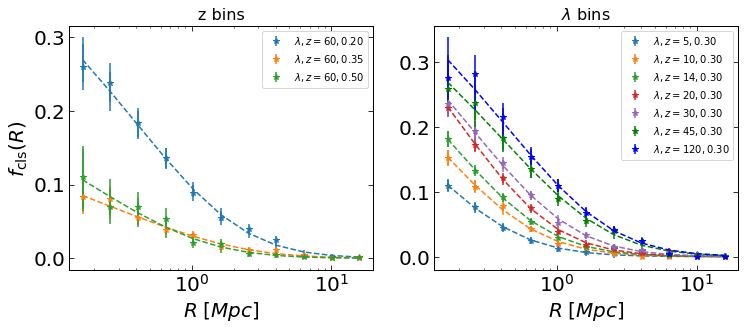

In [482]:
plt.figure(figsize=(12,4.5))

plt.subplot(121)
zmean = zbins[:-1]+0.0025
for zi,ci in zip(zmean,colors[:3]):
    plot_data(l=60, z=zi, color=ci, fmt='*')
    plot_fit(l=60, z=zi, color=ci)
    
plt.legend()
plt.ylabel(r'$f_{\rm cls}(R)$')
plt.title(r'z bins',fontsize=16)

plt.subplot(122)
lbdmean = lbdbins[:-1]
for li, ci in zip(lbdmean, colors):
    plot_data(li, z=0.3, color=ci, fmt='*')
    plot_fit(l=li, z=0.3, color=ci)
plt.legend()
plt.title(r'$\lambda$ bins',fontsize=16)

In [483]:
def fit_data(l,z):
    rd, b, b_err = intep_desy1_data(l,z)
    popt, pcov = curve_fit(Boost_Factor_Model, rd, b, sigma=np.sqrt(b_err**2+0.03**2))
    return popt, pcov

In [484]:
fitparams = dict()
fitparams['lambda'] = lbdbins[:-1]#(lbdmean+np.diff(lbdbins)/2.).astype(float)
# fitparams['lambda'][-1] = 120
fitparams['redshift'] = zbins[:-1]#(zmean+np.diff(zbins)/2.).astype(float)
# fitparams['b0'] = np.zeros((lbdmean.size*zmean.size,2))
# fitparams['rs'] = np.zeros((lbdmean.size*zmean.size,2))

b0, cb0 = [], []
rs, crs = [], []
for i,li in enumerate(lbdmean):
    r1, r2 = [], []
    c1, c2 = [], []
    for j,zi in enumerate(zmean):
        pars, covp = fit_data(li,zi)
        ij = (i*zmean.size)+j
        r1.append(pars[0])
        c1.append(covp[0,0])
        
        r2.append(pars[1])
        c2.append(covp[1,1])
    b0.append(r2)
    cb0.append(c2)
    
    rs.append(r1)
    crs.append(c1)

In [674]:
fitparams['b0'] = np.array(b0)
fitparams['rs'] = np.array(rs)

fitparams['b0_err'] = np.array(cb0)
fitparams['rs_err'] = np.array(crs)

In [486]:
fitparams['b0']

array([[0.15118265, 0.09541065, 0.14909014],
       [0.17348479, 0.05853046, 0.09366364],
       [0.20107862, 0.07296284, 0.087792  ],
       [0.26548733, 0.05870233, 0.05506836],
       [0.20696555, 0.05590278, 0.04740736],
       [0.17685159, 0.04151177, 0.06101111],
       [0.19852435, 0.0637635 , 0.05677087]])

In [675]:
fitparams['b0'][:,-1] = fitparams['b0'][:,-2]

In [676]:
from scipy.interpolate import interp1d, RectBivariateSpline

rs_interp = RectBivariateSpline(fitparams['redshift'], fitparams['lambda'], fitparams['rs'].T, kx=1, ky=1)
b0_interp = RectBivariateSpline(fitparams['redshift'], fitparams['lambda'], fitparams['b0'].T, kx=1, ky=1)


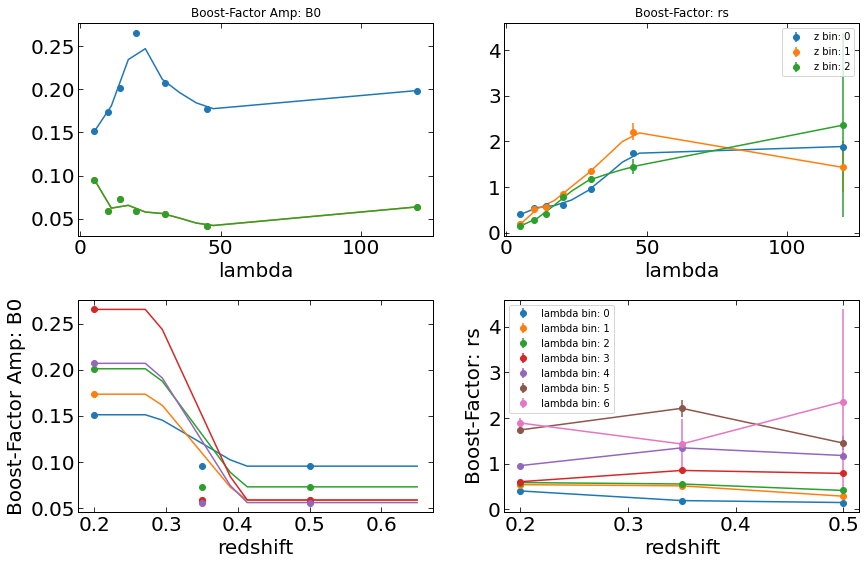

In [677]:
plt.figure(figsize=(14,9))

plt.subplot(2, 2, 1)

for i in range(3):
    zi = fitparams['redshift'][i]
    b0inter = b0_interp(zi, np.linspace(5, 120,20))
    p = plt.plot(np.linspace(5, 120,20), b0inter.flatten())
    plt.errorbar(fitparams['lambda'], fitparams['b0'][:,i], 
                 fmt='o', label='z bin: %i'%i, color=p[0].get_color())
    
# plt.legend(ncol=1)
plt.xlabel('lambda')
plt.title('Boost-Factor Amp: B0')

plt.subplot(2,2,2)
for i in range(3):
    rsinter = rs_interp(fitparams['redshift'][i], np.linspace(5, 120,20))
    p = plt.plot(np.linspace(5, 120,20), rsinter.flatten())
    plt.errorbar(fitparams['lambda'], fitparams['rs'][:,i], yerr=fitparams['rs_err'][:,i], 
                 fmt='o', label='z bin: %i'%i, color=p[0].get_color())

# plt.plot([30], [0.], color='k', label='Fitted Model')
plt.legend(ncol=1)
plt.xlabel('lambda')
plt.title('Boost-Factor: rs')

plt.subplot(2,2,3)
for i in range(5):
    b0inter = b0_interp(np.linspace(0.1, 0.65, 20), fitparams['lambda'][i])
    p = plt.plot(np.linspace(0.2, 0.65, 20), b0inter.flatten())
    plt.errorbar(fitparams['redshift'], fitparams['b0'][i], yerr=fitparams['b0_err'][i], 
                 fmt='o', label='z bin: %i'%i, color=p[0].get_color())
    
# plt.legend(ncol=1)
plt.xlabel('redshift')
plt.ylabel('Boost-Factor Amp: B0')

plt.subplot(2,2,4)
for i in range(fitparams['lambda'].size):
    p = plt.plot(fitparams['redshift'], fitparams['rs'][i])
    plt.errorbar(fitparams['redshift'], fitparams['rs'][i], yerr=fitparams['rs_err'][i], 
                 fmt='o', label='lambda bin: %i'%i, color=p[0].get_color())
    
plt.legend(ncol=1)
plt.xlabel('redshift')
plt.ylabel('Boost-Factor: rs')
plt.subplots_adjust(hspace=0.3)

## Interpolate $f_{\rm cl}(R)$

In [678]:
rmin, rmax, Nrbins = 0.05, 15., 100
radii = np.logspace(np.log10(rmin), np.log(rmax), Nrbins) 

In [679]:
def fcl_interp(zval,lval):
    b0i = b0_interp(zval,lval).flatten()
    rsi = rs_interp(zval,lval).flatten()
    
    binterp = Boost_Factor_Model(radii, rsi, b0i)
    return 1- 1./binterp

Text(0.5, 1.0, '$\\lambda$ bins')

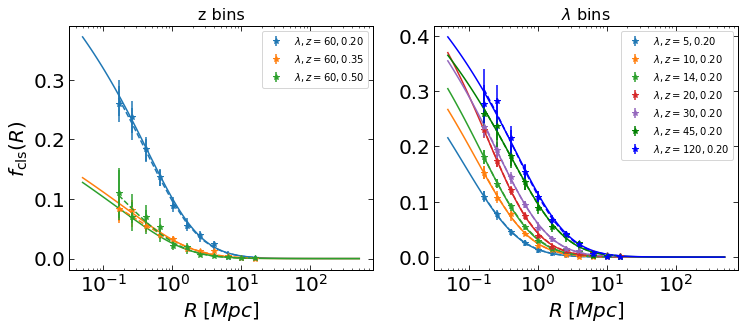

In [683]:
plt.figure(figsize=(12,4.5))

plt.subplot(121)
zmean = zbins[:-1]
for zi,ci in zip(zmean,colors[:3]):
    plt.plot(radii, fcl_interp(zi, 60), color=ci)
    plot_data(l=60, z=zi, color=ci, fmt='*')
    plot_fit(l=60, z=zi, color=ci)
    
plt.legend()
plt.ylabel(r'$f_{\rm cls}(R)$')
plt.title(r'z bins',fontsize=16)

plt.subplot(122)
lbdmean = lbdbins[:-1]
for li, ci in zip(lbdmean, colors):
    plt.plot(radii, fcl_interp(0.2, li), color=ci)
    plot_data(li, z=0.2, color=ci, fmt='*')
    plot_fit(l=li, z=0.2, color=ci)
plt.legend()
plt.title(r'$\lambda$ bins',fontsize=16)

In [681]:
rs_interp(0.3, 60)

array([[1.95989176]])

## Create Photo-z Distribution

### Cluster Photo-z: Lorentianz

In [658]:
zvec = np.linspace(0.1, 1.1, 100)

def lorentianz(x, x0, gamma):
    den = np.pi*gamma
    den*= (1+((x-x0)/gamma)**2)
    return 1/den

def gaussian(x, x0, sigma):
    arg = (x-x0)/sigma
    return np.exp(-arg**2)/np.sqrt(2*np.pi*sigma**2)

def compute_pz_cls(zvec, z0, sigma):
    # converts std to mad
    sigma *= (1+z0)*np.sqrt(2/np.pi)
    res = lorentianz(zvec, z0, sigma)
    #res = gaussian(zvec, z0, sigma/np.sqrt(2/np.pi))
    return res

In [659]:
def get_pz_total(r, lb, z, zvec, sigmaz=0.03, delta_z=0.1):
    fcl_vec = fcl_interp(z, lb)
    fcls = interp1d(np.log10(radii), fcl_vec)(np.log10(r))
    pz_cls = compute_pz_cls(zvec, z, sigmaz)
    pz_bg  =  pz_interp(zvec)
    
    heaviside = np.where(zvec>=z+delta_z, 1, 0)
    
    n2 = np.trapz(heaviside*pz_bg, x=zvec)
    n1 = np.trapz(heaviside*pz_cls, x=zvec)

    pz_tot = fcls*pz_cls/n1 + (1-fcls)*pz_bg/n2
    #pz_tot /= np.trapz(pz_tot, x=zvec)
    return pz_tot, fcls*pz_cls/n1

In [660]:
def plot_pz_total(r, l, z, zvec, sigmaz=0.05, ax=None):
    if ax is None: ax = plt.gca()
    fcl_vec = fcl_interp(l,z)
    fcls = np.interp(r, radii, fcl_vec)
    
    heaviside = np.where(zvec>zl+0.1, 1., 0.)
    pz_cls = compute_pz_cls(zvec, z, sigmaz)
    pz_total, _ = get_pz_total(r, l, z, zvec, sigmaz=sigmaz, delta_z=0.1)
    r1 = np.trapz(heaviside*pz_cls, x=zvec)
    r2 = np.trapz(pz_interp(zvec)*heaviside, x=zvec)
    
    plt.plot(zvec, fcls*pz_cls, color='tab:red', label=r'$P_{\rm cls}(z)$')
    plt.plot(zvec, (1-fcls)*pz_interp(zvec),'k--', label=r'$P_{\rm bg}(z)$')
    plt.plot(zvec, pz_total,'k-', label=r'$P_{\rm total}(z)$')
    plt.axvline(z+0.1,color='gray',lw=2,label=r'$z_{cls}+0.1$')
    plt.xlabel('redshift')

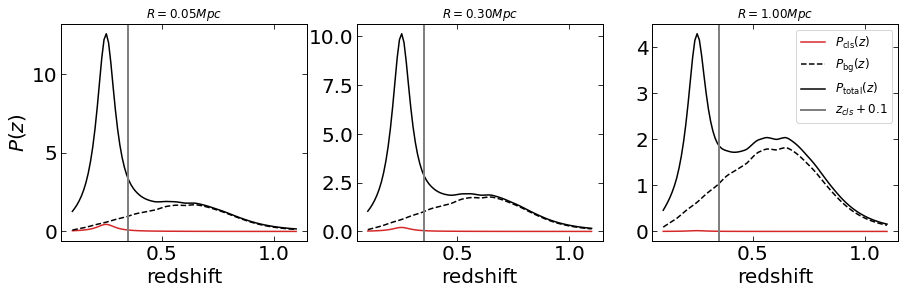

In [661]:
plt.figure(figsize=(15,4.))
l, z = 80, 0.25

plt.subplot(1, 3, 1)
plot_pz_total(0.1, l, z, zvec)
plt.ylabel(r'$P(z)$')
plt.title(r'$R=0.05 Mpc$')

plt.subplot(1, 3, 2)
plot_pz_total(0.2, l, z, zvec)
plt.title(r'$R=0.30 Mpc$')

plt.subplot(1, 3, 3)
plot_pz_total(1.0, l, z, zvec)
plt.title(r'$R=1.00 Mpc$')
plt.legend(fontsize=12, loc=1)

# $\beta$ as a function of Radii

In [662]:
def compute_z_src_eff_radii(zl, r, lb, delta_z=0.1, sigmaz=0.03, cosmo=cosmo0):
    # for a given zl
    z_source_vec = np.linspace(zl, 1.2, 100)

    # compute the normalized p(z_source)
    heaviside = np.where(z_source_vec>=zl+delta_z, 1, 0)
    
    # total pdf(z)
    pz_tot, fc = heaviside*get_pz_total(r, lb, zl, z_source_vec, sigmaz=sigmaz)
    pz_tot /= np.trapz(pz_tot, x=z_source_vec)
    fci = np.trapz(fc*heaviside, x=z_source_vec)
    #print('fc integration %.2f'%(np.trapz(fc*heaviside, x=z_source_vec)))
    
    # compute comving distances
    dl = cosmo.angular_diameter_distance(zl).value

    # compute betas
    ds = cosmo.angular_diameter_distance(z_source_vec).value
    dsl = cosmo.angular_diameter_distance_z1z2(zl, z_source_vec).value
    beta = dsl/ds

    # integrate over betas
    beta_mean = np.trapz(pz_tot*beta, x=z_source_vec)

    # effective redshift source
    z_src_eff = np.interp(beta_mean, beta, z_source_vec)
    
    return fci, beta_mean

In [663]:
dz=0.05
zarray = np.arange(0.2, 0.65+dz, dz)
rarray = np.logspace(-1, np.log10(10), 10)

def get_beta_2d(lb):
    beta_2d = np.zeros((zarray.size, rarray.size))
    zsrc_2d = np.zeros((zarray.size, rarray.size))
    for i,zl in enumerate(zarray):
        for j,ri in enumerate(rarray):
            zeff, beff = compute_z_src_eff_radii(zl, ri, lb, delta_z=0.1, cosmo=cosmo0)
            beta_2d[i,j] = beff
            zsrc_2d[i,j] = zeff
    return zsrc_2d, beta_2d

Text(0.5, 0, '$R$ [Mpc]')

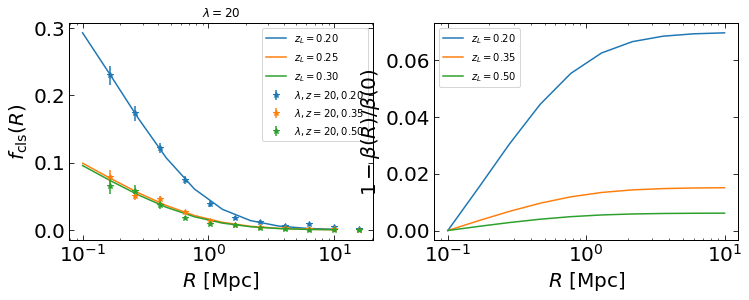

In [696]:
plt.figure(figsize=(12,4.))

li = lbdbins[3]
zsrc_2d, beta_2d = get_beta_2d(li)

plt.subplot(1,2,1)
plt.xscale('log')
for i, ci in enumerate(colors[:3]):
    zi = zmean[i]
    ix = np.interp(zi, zarray, np.arange(zarray.size)).astype(int)
    plt.plot(rarray, zsrc_2d[ix], color=ci, label=r'$z_L =%.2f$'%(zarray[i]))
    plot_data(li, z=zi, color=ci, fmt='*')
    #plt.plot(radii, fcl_interp(zarray[i], 60), ls='--', color=ci)
    
plt.legend()
plt.title(r'$\lambda = %i $'%li)
plt.ylabel(r'$f_{\rm cls}(R)$')
plt.xlabel(r'$R$ [Mpc]')

plt.subplot(1,2,2)
plt.xscale('log')
for i, ci in enumerate(colors[:3]):
    zi = zmean[i]
    ix = np.interp(zi, zarray, np.arange(zarray.size)).astype(int)
    plt.plot(rarray, (beta_2d[ix]-beta_2d[ix][0])/beta_2d[i][0], label=r'$z_L =%.2f$'%(zi))
    #plt.plot(rarray, zsrc_2d[i], label=r'$z_L =%.2f$'%(zarray[i]))
    
plt.legend()
plt.ylabel(r'$1- \beta(R)/\beta(0)$')
plt.xlabel(r'$R$ [Mpc]')


Text(0.5, 0, '$R$ [Mpc]')

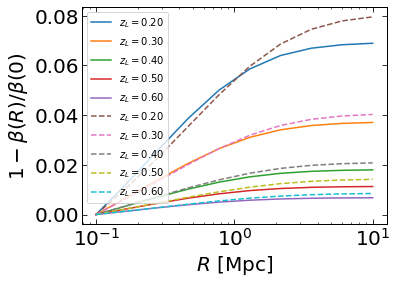

In [686]:
plt.figure(figsize=(12,4.))
zsrc_2d, beta_2d = get_beta_2d(30)

plt.subplot(1,2,1)
plt.xscale('log')
for i in np.arange(0, zarray.size, 2):
    plt.plot(rarray, (beta_2d[i]-beta_2d[i][0])/beta_2d[i][0], label=r'$z_L =%.2f$'%(zarray[i]))
    #plt.plot(rarray, zsrc_2d[i], label=r'$z_L =%.2f$'%(zarray[i]))
    
plt.legend()
plt.ylabel(r'$1- \beta(R)/\beta(0)$')
plt.xlabel(r'$R$ [Mpc]')

zsrc_2d, beta_2d = get_beta_2d(100)
# plt.subplot(1,2,2)
plt.xscale('log')
for i in np.arange(0, zarray.size, 2):
    plt.plot(rarray, (beta_2d[i]-beta_2d[i][0])/beta_2d[i][0], ls='--', label=r'$z_L =%.2f$'%(zarray[i]))
    #plt.plot(rarray, zsrc_2d[i], ls='--', label=r'$z_L =%.2f$'%(zarray[i]))
plt.legend()
plt.ylabel(r'$1- \beta(R)/\beta(0)$')
plt.xlabel(r'$R$ [Mpc]')

Text(0.5, 0, '$R$ [Mpc]')

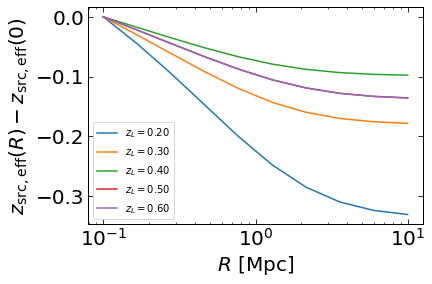

In [666]:
plt.xscale('log')
for i in np.arange(0, zarray.size, 2):
    plt.plot(rarray, (zsrc_2d[i]-zsrc_2d[i][0]), label=r'$z_L =%.2f$'%(zarray[i]))
plt.legend()
plt.ylabel(r'$z_{\rm src, eff}(R) - z_{\rm src, eff}(0)$')
plt.xlabel(r'$R$ [Mpc]')

## How Does this depends on cosmology?

In [223]:
cosmos = []
omega_vec = [0.10, 0.15, 0.2, 0.25, 0.3, 0.35]
for omi in omega_vec:
    cosmos.append(FlatLambdaCDM(H0=70, Om0=omi, Tcmb0=2.725))

# for hi in np.linspace(65, 75, 4):
#     cosmos.append(FlatLambdaCDM(H0=hi, Om0=0.3, Tcmb0=2.725))

In [224]:
z_eff_sources_cosmo, b_eff_sources_cosmo =[], []
for cosmoi in cosmos:
    z_eff_sources_cosmo.append(np.array([compute_z_src_eff(zl, cosmo=cosmoi)[0] for zl in zarray]))
    b_eff_sources_cosmo.append(np.array([compute_z_src_eff(zl, cosmo=cosmoi)[1] for zl in zarray]))

Text(0.5, 1.0, 'Effective :$\\left<\\beta\\right>$')

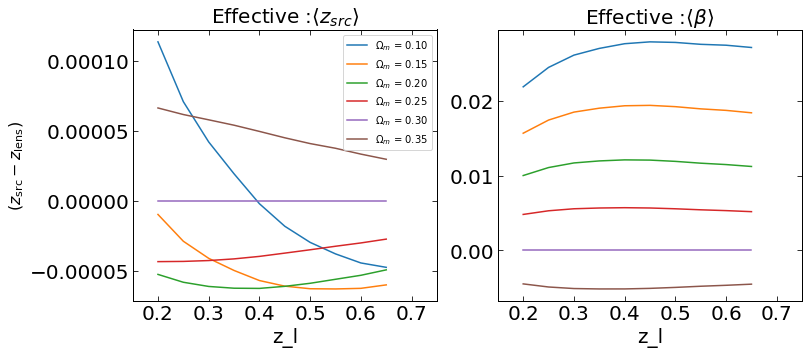

In [225]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(121)
for i, z_eff_sources in enumerate(z_eff_sources_cosmo):
    plt.plot(zarray, (z_eff_sources-z_eff_sources_cosmo[4]), 
             label=r'$\Omega_m$ = %.2f'%omega_vec[i])
    
plt.xlim(0.15, 0.75)
# plt.ylim(0.22, 0.42)
_ = plt.xticks(np.linspace(0.2, 0.7, 6))
plt.legend()
plt.xlabel('z_l')
plt.ylabel(r'$(z_{\rm src} - z_{\rm lens})$', fontsize=16)
plt.title(r'Effective :$\left<z_{src}\right>$', fontsize=20)

plt.subplot(122)
for b_eff_sources in b_eff_sources_cosmo:
    plt.plot(zarray, b_eff_sources-b_eff_sources_cosmo[4])

plt.xlim(0.15, 0.75)
_ = plt.xticks(np.linspace(0.2, 0.7, 6))
plt.xlabel('z_l')
plt.title(r'Effective :$\left<\beta\right>$', fontsize=20)
# plt.plot(zarray, beta)

### With Scaling Factor Correction

In [226]:
def scaleShiftCosmo(znew, cosmo):
    # redshift
    z_dc = np.linspace(0., 1.4, 50)
    
    # h0
    h0 = cosmo.H0/100.
    dc = cosmo.comoving_distance(z_dc).value
    
    # fiducical cosmology
    h0_fid = cosmo0.H0/100.
    dc_fid = cosmo0.comoving_distance(z_dc).value
    
    # scale shift
    scale_shift_vec = dc/dc_fid
    
    # interpolate for the new redshift
    scale_shift = np.interp(znew, z_dc, scale_shift_vec)
    return scale_shift

def beta_cosmo_corr(zS, zL, beta_fid, cosmo=cosmo):
    scale_src = scaleShiftCosmo(zS, cosmo)
    scale_lens= scaleShiftCosmo(zL, cosmo)
    scale_ratio = scale_src/scale_lens
    print(scale_ratio)
    return 1 - scale_ratio*(1-beta_fid)

NameError: name 'cosmo' is not defined

In [227]:
b_eff_cosmo_corr = [beta_cosmo_corr(zi, zarray, bi, cosmo) for zi, bi, cosmo 
                    in zip(z_eff_sources_cosmo, b_eff_sources_cosmo, cosmos) ]

NameError: name 'beta_cosmo_corr' is not defined

Text(0.5, 1.0, 'Effective :$\\left<\\beta\\right>$')

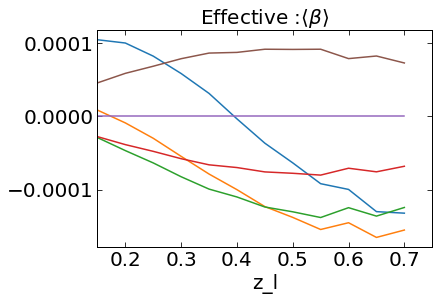

In [647]:
for b_eff_sources in b_eff_cosmo_corr:
    plt.plot(zarray, (b_eff_sources-b_eff_sources_cosmo[4])/b_eff_sources_cosmo[4])

plt.xlim(0.15, 0.75)
_ = plt.xticks(np.linspace(0.2, 0.7, 6))
plt.xlabel('z_l')
plt.title(r'Effective :$\left<\beta\right>$', fontsize=20)


After the cosmological correction the difference is in the order of 0.01 %. 

## Checking Mass-Concentration Relation

https://arxiv.org/pdf/1812.05995.pdf (equation 68) Dufy et al. 2008

In [53]:
Mp = 2e12*0.7 # Msun
def conc(M,z):
    c = 7.85*(M/Mp)**(-0.081)
    c*= (1+z)**(-0.71)
    return c

In [54]:
mass = np.logspace(13.5, 15.1, 21)
zvec = np.arange(0.2, 0.70+0.1, 0.1)

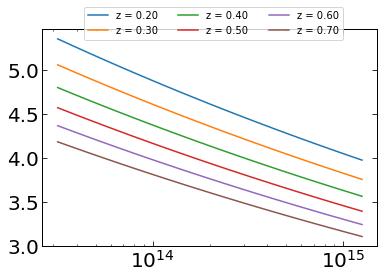

In [55]:
plt.xscale('log')
c033 = conc(mass, 0.4)
for zi in zvec:
    plt.plot(mass, conc(mass, zi), label='z = %.2f'%zi)
    
plt.legend(loc=(0.125,0.95), ncol=3, frameon=True)

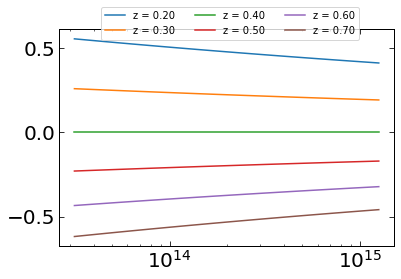

In [56]:
plt.xscale('log')
c033 = conc(mass, 0.4)
for zi in zvec:
    plt.plot(mass, conc(mass, zi)-c033, label='z = %.2f'%zi)
    
plt.legend(loc=(0.125,0.95), ncol=3, frameon=True)

In [57]:
cvec = np.linspace(3, 5, 3)
r = np.logspace(-1, 1, 10)

In [58]:
np.repeat(r, cvec.size)

array([ 0.1       ,  0.1       ,  0.1       ,  0.16681005,  0.16681005,
        0.16681005,  0.27825594,  0.27825594,  0.27825594,  0.46415888,
        0.46415888,  0.46415888,  0.77426368,  0.77426368,  0.77426368,
        1.29154967,  1.29154967,  1.29154967,  2.15443469,  2.15443469,
        2.15443469,  3.59381366,  3.59381366,  3.59381366,  5.9948425 ,
        5.9948425 ,  5.9948425 , 10.        , 10.        , 10.        ])

In [640]:
lbdbins =  np.array([20, 30, 45, 60, 300])
lbdmeans = 0.5*(lbdbins[1:]+lbdbins[:-1])
lbdmeans

array([ 25. ,  37.5,  52.5, 180. ])

In [641]:
np.repeat(lbdmeans, 3)

array([ 25. ,  25. ,  25. ,  37.5,  37.5,  37.5,  52.5,  52.5,  52.5,
       180. , 180. , 180. ])

In [692]:
def area_intersection(r_mis, r_lambda):
    # separation normalized by r_lambda
    x = r_mis/r_lambda
    
    # intersection area of two circles
    a_in = 2*r_lambda**2

    a_in *= np.arccos(x/2.) - (x/2.)*np.sqrt(1-(x/2.)**2)
    return a_in

In [710]:
def area_intersection(r_mis, r_lambda):
    # separation normalized by r_lambda
    x = r_mis/r_lambda
    
    # intersection area of two circles
    a_in = 2*r_lambda**2

    a_in *= np.arccos(x/2.) - (x/2)*np.sqrt(1-(x/2.)**2)
    return a_in

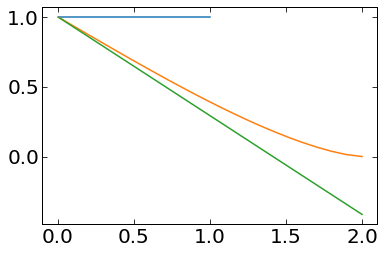

In [721]:
r_mis_vec = np.logspace(-2, np.log10(2), 100)
plt.plot([0,1], [1., 1.])
plt.plot(r_mis_vec, area_intersection(r_mis_vec, 1.)/np.pi)
plt.plot(r_mis_vec, 1-r_mis_vec/np.sqrt(2))

In [728]:
def gaussian(x,x0,sigma):
    return np.exp(-((x-x0)/sigma)**2)/np.sqrt(2*np.pi*sigma)

def area_model(r_mis, r_lambda):
    x = r_mis/r_lambda
    xx, xx2 = np.meshgrid(x, x)
    
    alpha  = 1.66
    a = 0.26
    b = 1.43
    y_mean = np.exp(-xx**2/alpha**2)
    sigma = a*np.arctan(b*xx)
    
    return gaussian(x, y_mean, sigma)

In [745]:
r_mis_vec = np.logspace(-2, np.log10(2), 100)
x = r_mis_vec/1.
xx, xx2 = np.meshgrid(x, x)

alpha  = 1.66
a = 0.26
b = 1.43
y_mean = np.exp(-x**2/alpha**2)
sigma = a*np.arctan(b*x)

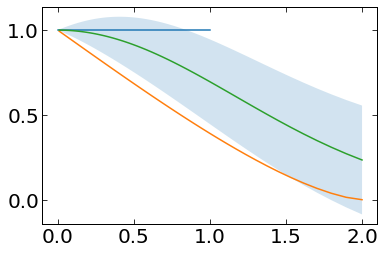

In [752]:
plt.plot([0,1], [1., 1.])
plt.plot(r_mis_vec, area_intersection(r_mis_vec, 1.)/np.pi)
plt.fill_between(x, y_mean -sigma, y_mean +sigma, alpha=0.2)
plt.plot(x, y_mean)

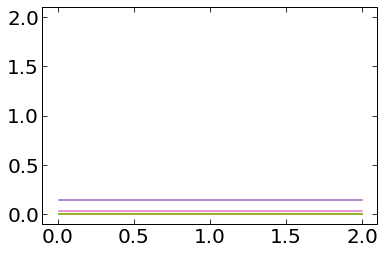

In [733]:
r_mis_vec = np.logspace(-2, np.log10(2), 10)
# plt.plot([0,1], [1., 1.])
# plt.plot(r_mis_vec, area_intersection(r_mis_vec, 1.)/np.pi)
# plt.plot(r_mis_vec, 1-r_mis_vec/np.sqrt(2))
y_vec = area_model(r_mis_vec, 1.).T
for xi,yi in zip(r_mis_vec, y_vec):
    plt.plot(r_mis_vec, yi, xi)

In [756]:
10**5/1000

100.0